# 0.0. Understanding the problem

--Goal:
    
    --1.0 Predict the first destination that the new user will choose
    
    --Why?
        --What is the business model of Airbnb?
            --Marketplace (connect people who offer acomodation to whom are seeking a place)
            --Offer
                --Portfolio size
                --Portfolio diversity and density
                --Average price
                
            --Demand
                --Number of users
                --LTV (lifetime value)
                --CAC (client acquisition cost)
                
                Gross Revenue = (Fee*Number of clients) - CAC
                
--Solution:
    
    --Predictive model for the first destination of new user
    --1.0 Prediction save in a database
    --2.0 API
        --Input: User and features
        --Output: User and feature with destination prediction
        

# Module 1

## 0.0. Imports

In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install scikit-plot
#!pip install imblearn
#!pip install delayed
#!pip install pandas-profiling
#!pip install matplotlib
#!pip install category_encoders

import random
import pickle

import numpy   as np
import pandas  as pd
import seaborn as sns

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from scipy      import stats           as ss
from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c
from keras      import models          as ml
from keras      import layers          as l
from matplotlib import pyplot          as plt

from IPython.display   import Image
from category_encoders import TargetEncoder
from pandas_profiling  import ProfileReport

### 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 0.2. Loading Data

In [3]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [4]:
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [7]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [10]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)


# ========== User =================
# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


# ========== Sessions =================
#user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

#action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4. Change Data Type

In [13]:
 df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [14]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(int)

## 1.5. Check Balanced Data

In [15]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6. Descriptive Analysis

In [16]:
#Users
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

#Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64','float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.6.1 Numerical - Users

In [17]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2 Numerical - Sessions

In [18]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorical - Users

In [19]:
cat_attributes.drop(['id','age'], axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4 - Categorical - Sessions

In [20]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


### 1.6.5 Correlation Matrix - Sessions

In [21]:
#list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

In [22]:
corr_dict[feat]

[0.25984796015349226,
 0.08204073846721649,
 0.2196221769687879,
 1.000000705454337]

In [23]:
corr_dict[ref]

[0.25984796015349226,
 0.08204073846721649,
 0.2196221769687879,
 1.000000705454337]

<AxesSubplot:>

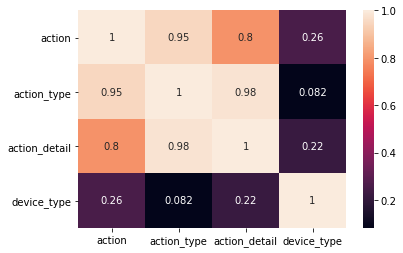

In [24]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0. Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

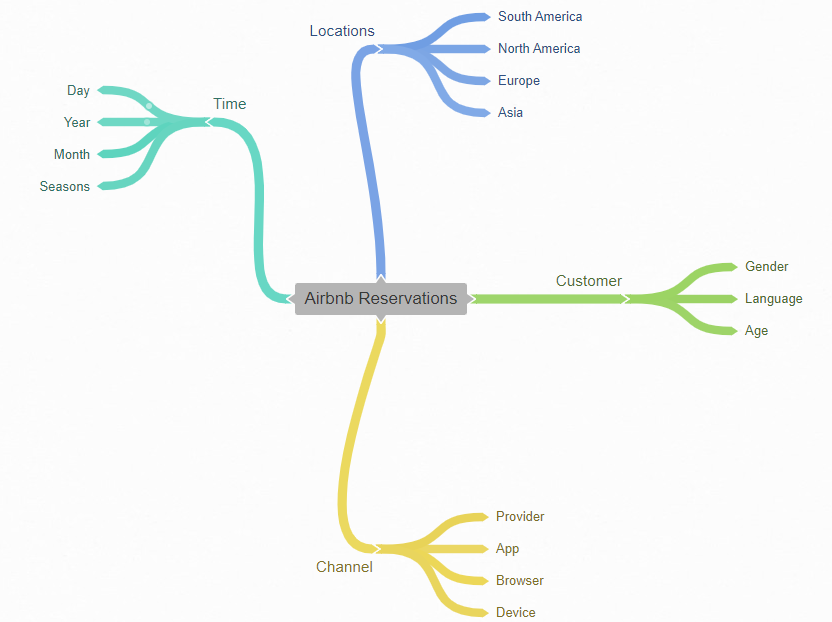

In [26]:
Image('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/Mindmap.png')

## 2.2. Create New Features

In [27]:
#days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

#days from first active upt to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)


# ================== First Active ==================
#year first active
df2['year_first_active'] = df2['first_active'].dt.year

#month first active
df2['month_first_active'] = df2['first_active'].dt.month

#day first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week
df2['week_of_year_first_active'] = np.asarray(df2['week_of_year_first_active']).astype(np.int64)


# ================== First Booking ==================
#year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week
df2['week_of_year_first_booking'] = np.asarray(df2['week_of_year_first_booking']).astype(np.int64)


# ================== First Account Created =================
#year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

#month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

#day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

#day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week
df2['week_of_year_account_created'] = np.asarray(df2['week_of_year_account_created']).astype(np.int64)

In [28]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int32
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

# 3.0. Data Filtering

In [29]:
df3 = df2.copy()

In [30]:
df2.head().T

,1,2,3,4,6
id,820tgsjxq7,4ft3gnwmtx,bjjt8pjhuk,87mebub9p4,lsw9q7uk0j
date_account_created,2011-05-25 00:00:00,2010-09-28 00:00:00,2011-12-05 00:00:00,2010-09-14 00:00:00,2010-01-02 00:00:00
timestamp_first_active,2009-05-23 17:48:09,2009-06-09 23:12:47,2009-10-31 06:01:29,2009-12-08 06:11:05,2010-01-02 01:25:58
date_first_booking,2015-06-29 00:00:00,2010-08-02 00:00:00,2012-09-08 00:00:00,2010-02-18 00:00:00,2010-01-05 00:00:00
gender,MALE,FEMALE,FEMALE,-unknown-,FEMALE
age,38,56,42,41,46
signup_method,facebook,basic,facebook,basic,basic
signup_flow,0,3,0,0,0
language,en,en,en,en,en
affiliate_channel,seo,direct,direct,direct,other


## 3.1. Filtering Rows

In [31]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

## 3.2. Columns Selection

In [32]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

# 4.0. Balanced Dataset

In [33]:
df4 = df3.copy()
#df4.shape

In [34]:
#Encoder Categorical Variables
ohe = pp.OneHotEncoder()

#Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

#Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

#encoding
df4_dummy = pd.DataFrame(ohe.fit_transform( df4[ col_cat]).toarray(), index=df4.index)

#join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(122636, 236)

## 4.1. Random Undersampling

In [34]:
#ratio_balanced
ratio_balanced = {'NDF': 10000}

#define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

#apply sampler
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [35]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [36]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [37]:
#define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

#apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [38]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [39]:
y_over.value_counts()

PT       54852
US       54852
ES       54852
GB       54852
NDF      54852
AU       54852
other    54852
FR       54852
DE       54852
CA       54852
NL       54852
IT       54852
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [40]:
ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [41]:
#define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

In [42]:
#apply sampler
#X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

In [43]:
#pickle.dump(X_smt, open('X_smt2.pkl','wb'))
#pickle.dump(y_smt, open('y_smt2.pkl','wb'))

In [44]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [45]:
y_over.value_counts()

PT       54852
US       54852
ES       54852
GB       54852
NDF      54852
AU       54852
other    54852
FR       54852
DE       54852
CA       54852
NL       54852
IT       54852
Name: country_destination, dtype: int64

In [46]:
X_smt = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/X_smt2.pkl', 'rb'))
y_smt = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/y_smt2.pkl', 'rb'))

In [47]:
#numerical data
df43 = X_smt[ col_num ]

#categorical data
df44 = X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

#join numerical categorical
df46 = pd.concat([df43, df45], axis=1)
df46['country_destination'] = y_smt

# 5.0. Exploratory Data Analysis

##  5.1. Hypothesys Validation ( Unbalanced Dataset )

In [60]:
 df51 = df4.copy()

**H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.

**VERDADEIRA** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

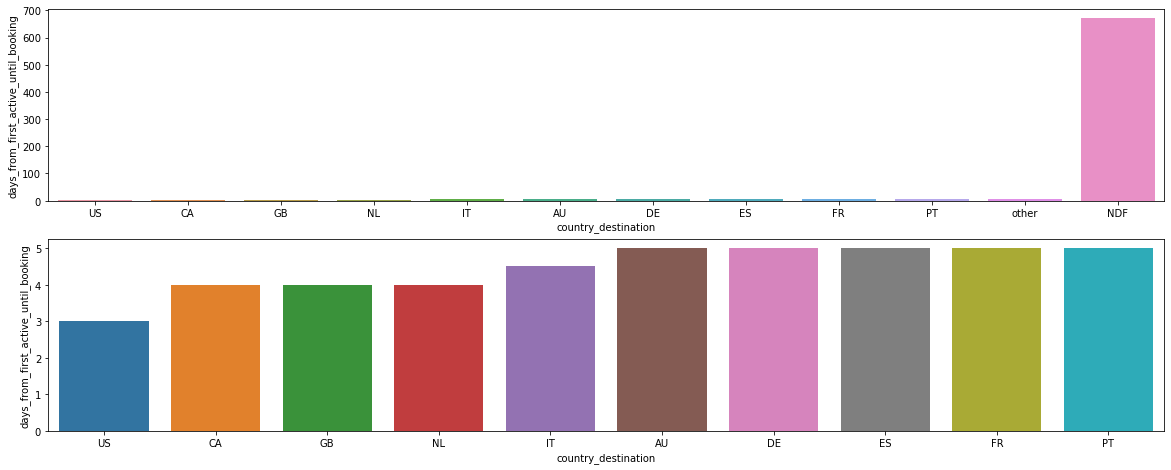

In [38]:
plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values('days_from_first_active_until_booking'))

# remove outlier
plt.subplot(3, 1, 2)
aux02 = df51[(df51['country_destination'] != 'NDF') & (df51['country_destination'] != 'other')]
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values('days_from_first_active_until_booking'))

In [39]:
#aux03 = df52[(df52['days_from_first_active_until_booking'] < 10) & (df52['country_destination'] == 'US')]['days_from_first_active_until_booking']
#plt.boxplot(aux03)

**H02.** Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.

**VERDADEIRA** Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

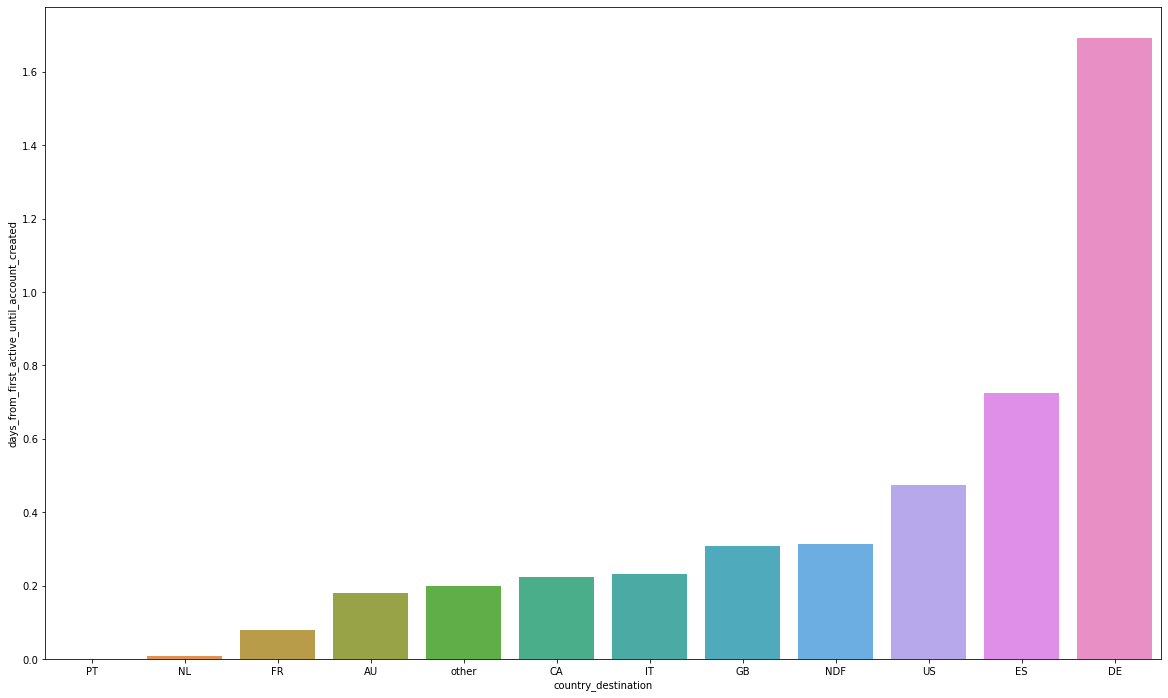

In [40]:
plt.figure(figsize=(20, 12))
aux01 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values('days_from_first_active_until_account_created'))

**H03.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**FALSA** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

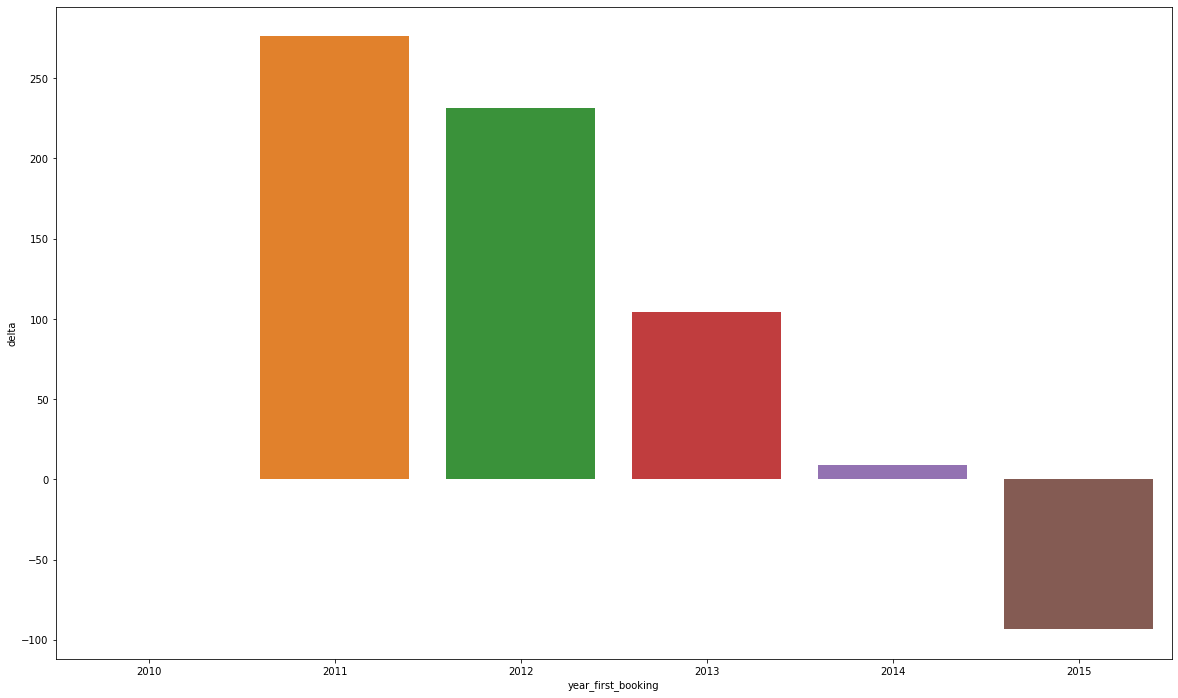

In [41]:
aux01 = df51[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'month_first_booking', 'country_destination']). \
                size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

plt.figure(figsize=(20,12))
sns.barplot(x='year_first_booking', y='delta', data=aux02)

In [42]:
#perc_dict = {}

#print(len(aux02['count']))

#for i in range(len(aux02['count'])):
#    if i != 5:
#        print(i)
#       y = aux02['year_first_booking'][i+1]
#        perc = ((aux02['count'][i+1]*100)/(aux02['count'][i]))-100
#        perc_dict[y] = perc
#    else:
#        exit

In [43]:
perc_d = {}
def perc_country(x): 
    j = len(x['count'])
    for i in range(len(x['count'])):
        if i != j:
            y = x['country_destination'][i]
            perc = ((x['count'][i]*100)/(x['count'][9]))-100
            perc_d[y] = perc
        else:
            return x
            exit

**H04.** Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA.

**FALSA** Mais de 99% das mulheres fazem reservas para os USA

In [44]:
#df51.dtypes

<AxesSubplot:xlabel='country_destination', ylabel='count'>

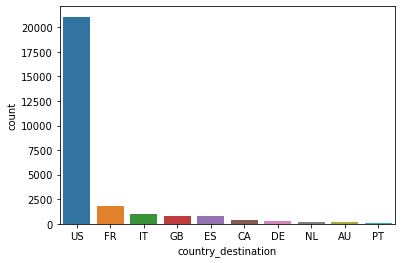

In [45]:
aux01 = df51[(df51['gender'] == 'FEMALE') & (df51['country_destination'] != 'NDF') 
             & (df51['country_destination'] != 'other')]

aux02 = aux01[['gender','country_destination']].\
                groupby(['gender','country_destination']). \
                size().reset_index().rename(columns={0:'count'})

perc_country(aux02)

sns.barplot(x='country_destination', y='count', data=aux02, order=aux02.sort_values('count', ascending=False).country_destination)

In [46]:
aux02

,gender,country_destination,count
0,FEMALE,AU,195
1,FEMALE,CA,422
2,FEMALE,DE,326
3,FEMALE,ES,797
4,FEMALE,FR,1795
5,FEMALE,GB,820
6,FEMALE,IT,1005
7,FEMALE,NL,230
8,FEMALE,PT,70
9,FEMALE,US,21067


In [47]:
perc_d

{'AU': -99.07438173446623,
 'CA': -97.99686713817819,
 'DE': -98.45255613044097,
 'ES': -96.21683201215171,
 'FR': -91.47956519675321,
 'GB': -96.10765652442208,
 'IT': -95.22950586224901,
 'NL': -98.90824512270376,
 'PT': -99.66772677647505,
 'US': 0.0}

**H05.** O canal de Marketing Google representa 40% das reservas para países fora dos USA.

**VERDADEIRA** 37,5% do canal de marketing para as reservas fora dos USA é o Google

In [48]:
df51['affiliate_provider'].value_counts()

direct                 78954
google                 29062
other                   7930
craigslist              2027
facebook                1568
bing                    1159
padmapper                463
facebook-open-graph      409
vast                     350
yahoo                    251
gsp                      185
meetup                   139
email-marketing           80
naver                     27
baidu                     15
yandex                    14
wayn                       3
Name: affiliate_provider, dtype: int64

<AxesSubplot:xlabel='affiliate_provider', ylabel='count'>

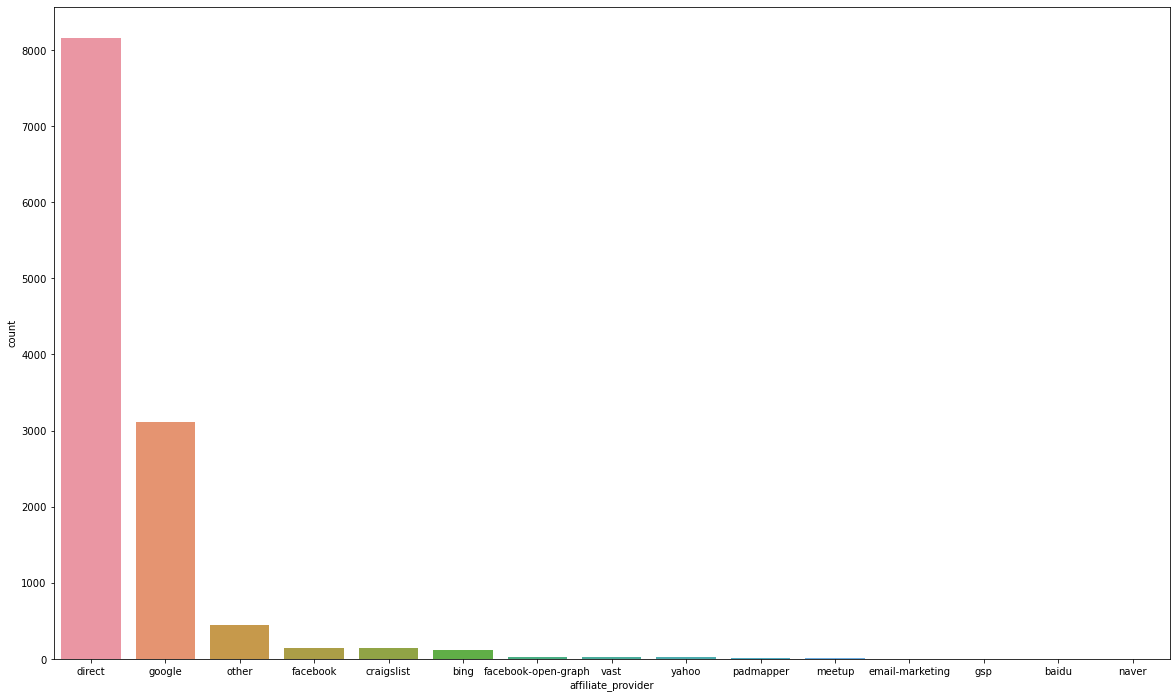

In [49]:
aux01 = df51[(df51['country_destination'] != 'NDF') & (df51['country_destination'] != 'other') 
             & (df51['country_destination'] != 'US')]

aux02 = aux01[['affiliate_provider','country_destination']].\
                groupby(['affiliate_provider']). \
                size().reset_index().rename(columns={0:'count'})

plt.figure(figsize=(20,12))
sns.barplot(x='affiliate_provider', y='count', data=aux02, order=aux02.sort_values('count',ascending=False).affiliate_provider)


**H06.** O destino dos USA representam mais de 20% em todos os canais.

**VERDADEIRA** 

In [50]:
aux01 = df51[(df51['country_destination'] != 'NDF') & (df51['country_destination'] != 'other') 
            & (df51['affiliate_provider'] != 'other') & (df51['affiliate_provider'] != 'facebook-open-graph')
            & (df51['affiliate_provider'] != 'vast') & (df51['affiliate_provider'] != 'yahoo')
            & (df51['affiliate_provider'] != 'padmapper') & (df51['affiliate_provider'] != 'meetup')
            & (df51['affiliate_provider'] != 'email-marketing') & (df51['affiliate_provider'] != 'gsp')
            & (df51['affiliate_provider'] != 'baidu') & (df51['affiliate_provider'] != 'naver')
            & (df51['affiliate_provider'] != 'bing') & (df51['affiliate_provider'] != 'craigslist')
            & (df51['affiliate_provider'] != 'facebook')]


aux02 = aux01[['country_destination', 'affiliate_provider']].\
                groupby(['country_destination', 'affiliate_provider']). \
                size().reset_index().rename(columns={0:'count'})
aux02
#plt.figure(figsize=(20,12))
#plt.legend()
#sns.barplot(x='affiliate_provider', y='count', data=aux02, order=aux02.sort_values('count',ascending=False).affiliate_provider)


,country_destination,affiliate_provider,count
0,AU,direct,300
1,AU,google,99
2,CA,direct,713
3,CA,google,249
4,DE,direct,550
5,DE,google,215
6,ES,direct,1157
7,ES,google,401
8,FR,direct,2433
9,FR,google,967


In [51]:
df51['affiliate_provider']

1             google
2             direct
3             direct
4             direct
6         craigslist
             ...    
213441        direct
213443        google
213445        google
213446        google
213448        direct
Name: affiliate_provider, Length: 122636, dtype: object

 **H07.** A idade média das pessoas é de 35 anos em todos os destinos.
 
 **FALSA** Em média são 37 anos

<AxesSubplot:xlabel='country_destination', ylabel='age'>

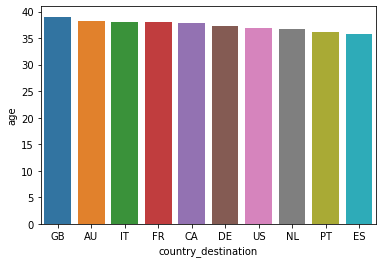

In [52]:
aux01 = df51[(df51['country_destination'] != 'NDF') & (df51['country_destination'] != 'other')]

aux02 = aux01[['age','country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='age', data=aux02, 
            order=aux02.sort_values('age',ascending=False).country_destination)

In [53]:
aux02.mean()

age    37.430953
dtype: float64

**H08.** A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90%

**VERDADEIRA**

In [54]:
df51['language'].value_counts()

en    118205
zh       901
fr       807
es       625
de       407
ko       395
it       347
ru       269
pt       169
ja       130
sv        79
nl        52
tr        45
pl        42
da        33
el        22
no        20
cs        18
th        17
id        17
hu        15
fi        11
is         4
ca         4
hr         2
Name: language, dtype: int64

In [55]:
aux01 = df51[(df51['country_destination'] != 'NDF') & (df51['country_destination'] != 'other')]

aux02 = aux01[['language','country_destination']].\
                groupby(['country_destination', 'language']). \
                size().reset_index().rename(columns={0:'count'})
#sns.barplot(x='country_destination', y='language', data=aux02, 
            #order=aux02.sort_values('age',ascending=False).country_destination)
aux02

,country_destination,language,count
0,AU,de,2
1,AU,en,428
2,AU,fr,2
3,AU,zh,1
4,CA,de,1
...,...,...,...
103,US,ru,59
104,US,sv,25
105,US,th,2
106,US,tr,13


**H10.** O número de reservas do Airbnb é crescente ao longo dos anos.

**VERDADEIRA**

In [59]:
aux01 = df51[['year_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'country_destination']). \
                size().reset_index().rename(columns={0:'count'})

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

#aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

aux02
#plt.figure(figsize=(20,12))
#sns.barplot(x='year_first_booking', y='count', data=aux02)

,year_first_booking,count
0,2010,872
1,2011,3620
2,2012,12021
3,2013,23898
4,2014,25800
5,2015,56425


**H11.** Reservas nas sextas-feiras são 20% maior do que outros dias da semana

In [44]:
df51['day_of_week_first_booking'].value_counts()

0    64567
1    10913
2    10909
3    10610
4    10180
5     7996
6     7461
Name: day_of_week_first_booking, dtype: int64

In [56]:
#df51.dtypes

In [69]:
day_of_week_map = {0: 'monday', 1:'tuesday', 2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'}
aux01 = df51.copy()
aux01['day_of_week_first_booking_map'] = df1['date_first_booking'].dt.dayofweek.map(day_of_week_map)
#aux01.head()

<AxesSubplot:xlabel='day_of_week_first_booking_map', ylabel='count'>

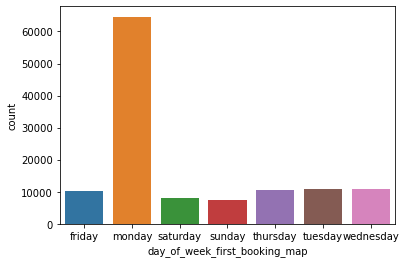

In [70]:
aux01 = aux01[['country_destination', 'day_of_week_first_booking_map']].\
                groupby(['day_of_week_first_booking_map']). \
                size().reset_index().rename(columns={0:'count'})

sns.barplot(x='day_of_week_first_booking_map', y='count', data=aux01)

## 5.2. Variables Impact (Balanced Dataset)

In [54]:
 df52 = df4.copy() #unbalanced dataset

### 5.2.1. Univariate Analysis

In [55]:
#profile = ProfileReport(df51, title='Airbnb Booking')
#profile.to_notebook_iframe()
#profile.to_file(output_file='airbnb_booking_statistics_after_cleaning.html')

In [56]:
# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

 ### 5.2.2 Bivariate Analysis

###  5.2.3. Multivariate Analysis

In [57]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

# 6.0. Data Preparation

In [58]:
df6 = df46.drop( cols, axis=1 )
df6.shape

(546589, 16)

In [59]:
df6.dtypes

signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of_week_account_created                       int64
week_of_year_account_created                      int64
gender                                           object
age                                              object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

## 6.1. Rescaling

In [60]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [61]:
#age - Standardization
df6['age'] = ss.fit_transform(df6[['age']].values)

#signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

#days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform(df6[['days_from_first_active_until_account_created']].values)

#days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

#year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)

##  6.2. Encoding

In [62]:
 te = TargetEncoder()

In [63]:
# gender - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['gender'], columns=['gender'] )

# signup_method - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_method'], columns=['signup_method'] )

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( c ) )

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( c ) )

C:\Users\Henrique\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Henrique\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


##  6.3. Transformation

In [64]:
 # week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/31 ) ) )
df6['day_account_created_cos'] = df6['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/31 ) ) )

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# 7.0. Feature Seleciotn

In [65]:
 df7 = df6.copy()

In [66]:
X = df7.drop(['country_destination'], axis=1)
y = df7['country_destination'].copy()

In [67]:
#split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 8.0. Machine Learning

## 8.1. Baseline Model

In [68]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)

### 8.1.1. Baseline Performance

Accuracy: 0.09158601511187545
Balanced Accuracy: 0.08308762180481995
Kappa Accuracy: -0.0003502314390733119
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7362
          CA       0.08      0.01      0.01      8609
          DE       0.08      0.01      0.02      7439
          ES       0.08      0.01      0.02     10084
          FR       0.08      0.03      0.04      8854
          GB       0.09      0.01      0.02     10560
          IT       0.07      0.02      0.02      7972
         NDF       0.10      0.45      0.16     10901
          NL       0.10      0.01      0.01      9547
          PT       0.08      0.00      0.00      9501
          US       0.09      0.39      0.14      9503
       other       0.09      0.07      0.08      8986

    accuracy                           0.09    109318
   macro avg       0.08      0.08      0.05    109318
weighted avg       0.08      0.09      0.05    109318



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

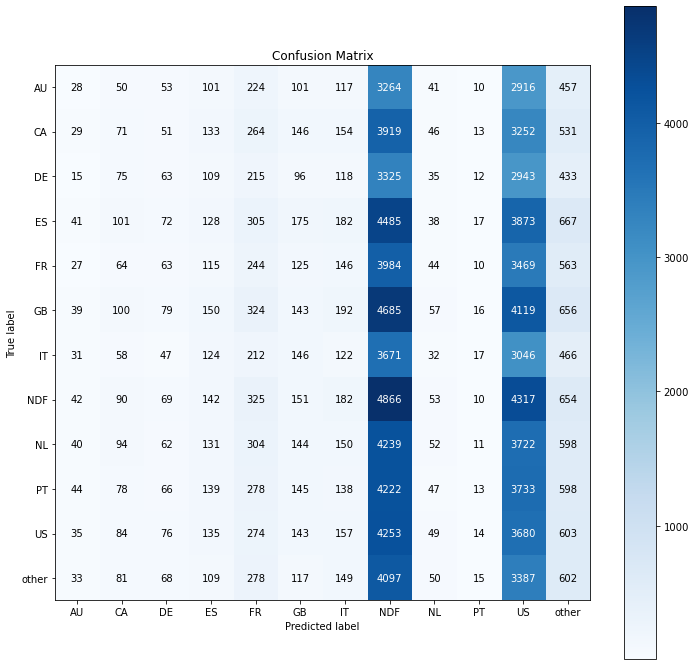

In [69]:
#accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

#balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

#Kappa metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Accuracy: {}'.format(kappa_random))

#Classification report
print( m.classification_report( y_test, yhat_random ) )

#Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 8.2. Neural Network - MLP

In [70]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [71]:
X_train.shape

(437271, 31)

In [72]:
# model definition
model = ml.Sequential()
model.add(l.Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
13665/13665 [==============================] - 32s 930us/step - loss: 2.2040 - accuracy: 0.2247
Epoch 2/100
13665/13665 [==============================] - 12s 908us/step - loss: 2.0339 - accuracy: 0.2765
Epoch 3/100
13665/13665 [==============================] - 12s 911us/step - loss: 1.9827 - accuracy: 0.2948
Epoch 4/100
13665/13665 [==============================] - 13s 929us/step - loss: 1.9539 - accuracy: 0.3051
Epoch 5/100
13665/13665 [==============================] - 13s 934us/step - loss: 1.9323 - accuracy: 0.3134
Epoch 6/100
13665/13665 [==============================] - 12s 910us/step - loss: 1.9222 - accuracy: 0.3170
Epoch 7/100
13665/13665 [==============================] - 12s 907us/step - loss: 1.9046 - accuracy: 0.3227
Epoch 8/100
13665/13665 [==============================] - 13s 915us/step - loss: 1.9023 - accuracy: 0.3223
Epoch 9/100
13665/13665 [==============================] - 13s 926us/step - loss: 1.8943 - accuracy: 0.3250
Epoch 10/100
13665/13665 [==

### 8.2.1. NN Performance

In [73]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn
                               )

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.34310909456814065
Balanced Accuracy: 0.3284984726129669
Kappa Accuracy: 0.2823602743261677


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

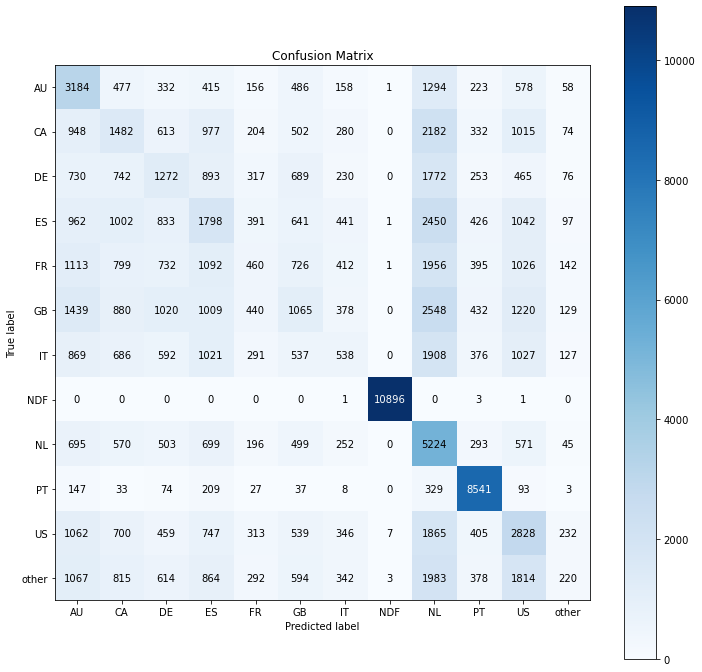

In [74]:
#accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

#Kappa metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Accuracy: {}'.format(kappa_nn))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 8.2.2. NN Performance - Cross-Validation

In [75]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

#for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    #get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    #prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    #metrics
    ##Balanced Accuracy
    baanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ##Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1


Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [76]:
pickle.dump(balanced_acc_list, open('balanced_acc_list.pkl','wb'))
pickle.dump(kappa_acc_list, open('kappa_acc_list.pkl','wb'))

In [ ]:
balanced_acc_list = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/balanced_acc_list.pkl', 'rb'))
kappa_acc_list.pkl = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/kappa_acc_list.pkl.pkl', 'rb'))

In [77]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list),2),
                                                np.round(np.std(balanced_acc_list),4)))
print('Avg Kappa Accuracy: {} +/- {}'.format(np.round(np.mean(kappa_acc_list),2),
                                             np.round(np.std(kappa_acc_list)),4))

Avg Balanced Accuracy: 0.33 +/- 0.0
Avg Kappa Accuracy: 0.4 +/- 0.0
